In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set_style("ticks")

rseed = 20090425, 19700903
np.random.seed(rseed)

Import relevant data from KQ4 spreadsheet.

In [2]:
kq4_data = (pd.read_excel('data/UF_KQ4_data_for_Chris_0127_2017_Full Data_Analysis_data.xlsx', sheetname='KQ4_Analysis_data', 
                         na_values=['NR', 'NA', 'ND'])
                .rename(columns={'LMS count used for \nsurvival analysis': 'lms_count',
                               'First_\nstaging': 'first_staging', 
                               'Range_\nFUP_Time': 'fup_range',
                                'Pre-op_dx': 'preop'}))

kq4_data.columns = kq4_data.columns.str.lower()

In [3]:
kq4_data.head()

,author,year,refid,lms total,lms_count,preop,study_inclusion,initial_surgery,morcellation,power,first_staging,upstaged,event_time,fup_range,outcome,age,menopausal_status
0,Einstein,2008,405,5.0,5.0,Benign,HYST+Uca_dx,LSC SCH,Yes,Yes,I,No,30.0,NaN,NED,NaN,NaN
1,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,LMYOM,Yes,Yes,I,Yes,61.0,NaN,NED,NaN,NaN
2,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,SCH,Yes,No,I,Yes,31.0,NaN,AWD,NaN,NaN
3,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,SCH BSO,No,No,I,No,37.0,NaN,NED,NaN,NaN
4,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,SCH BSO,No,No,I,Yes,6.0,NaN,AWD,NaN,NaN


In [4]:
kq4_data.refid.unique()

array([405, 753, 750, 145, 13, 38, 394, 783, 211, 811, 841, 752, 1807,
       1917, 1539, 2024, 2114, 1571, 1030, 900, 1206, '43_1799', 826, 364,
       932], dtype=object)

Distribution of age (if not missing)

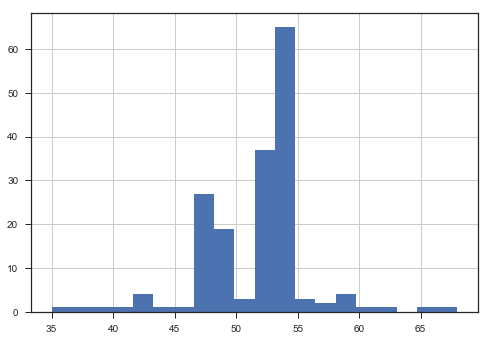

In [5]:
kq4_data.age.hist(bins=20)

Note that half the ages are missing:

In [6]:
kq4_data.isnull().mean().round(2)

author               0.00
year                 0.00
refid                0.00
lms total            0.94
lms_count            0.94
preop                0.09
study_inclusion      0.00
initial_surgery      0.00
morcellation         0.00
power                0.04
first_staging        0.10
upstaged             0.66
event_time           0.01
fup_range            0.99
outcome              0.00
age                  0.57
menopausal_status    0.86
dtype: float64

In [7]:
kq4_data.groupby('refid').year.max().value_counts()

2015    10
2016     6
2014     2
2008     2
2013     1
2012     1
2010     1
2009     1
1999     1
Name: year, dtype: int64

Drop those with missing `event_time`, `power` or `morcellation` covariates. Perhaps we can impute later.

In [8]:
kq4_data = kq4_data.dropna(subset=['morcellation', 'power', 'event_time']).reset_index(drop=True)

Values are a mess in several columns:

In [9]:
kq4_data.outcome.value_counts()

Alive    213
Dead     133
NED       26
AWD       12
Name: outcome, dtype: int64

In [10]:
kq4_data['preop'].value_counts()

Benign     235
benign     111
Benign       1
Name: preop, dtype: int64

In [11]:
kq4_data.outcome = kq4_data.outcome.replace({'Alive': 'alive',
                         'Dead': 'dead',
                         'AWD': 'awd',
                         'NED': 'ned'})
kq4_data.outcome.value_counts()

alive    213
dead     133
ned       26
awd       12
Name: outcome, dtype: int64

This is also a mess. Need to fix.

In [12]:
pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,No,Yes,no,yes
morcellation,,,,
No,231,0,0,0
Yes,70,40,0,0
no,0,0,5,0
yes,13,0,4,21


In [13]:
kq4_data.morcellation = kq4_data.morcellation.str.lower()
kq4_data.power = kq4_data.power.str.lower()

pd.crosstab(kq4_data.morcellation, kq4_data.power)

power,no,yes
morcellation,,
no,236,0
yes,87,61


Create death outcome column

In [14]:
kq4_data['died'] = (kq4_data.outcome=='dead').astype(int)
kq4_data.died.value_counts()

0    251
1    133
Name: died, dtype: int64

In [15]:
kq4_data.head()

,author,year,refid,lms total,lms_count,preop,study_inclusion,initial_surgery,morcellation,power,first_staging,upstaged,event_time,fup_range,outcome,age,menopausal_status,died
0,Einstein,2008,405,5.0,5.0,Benign,HYST+Uca_dx,LSC SCH,yes,yes,I,No,30.0,NaN,ned,NaN,NaN,0
1,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,LMYOM,yes,yes,I,Yes,61.0,NaN,ned,NaN,NaN,0
2,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,SCH,yes,no,I,Yes,31.0,NaN,awd,NaN,NaN,0
3,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,SCH BSO,no,no,I,No,37.0,NaN,ned,NaN,NaN,0
4,Einstein,2008,405,NaN,NaN,Benign,HYST+Uca_dx,SCH BSO,no,no,I,Yes,6.0,NaN,awd,NaN,NaN,0


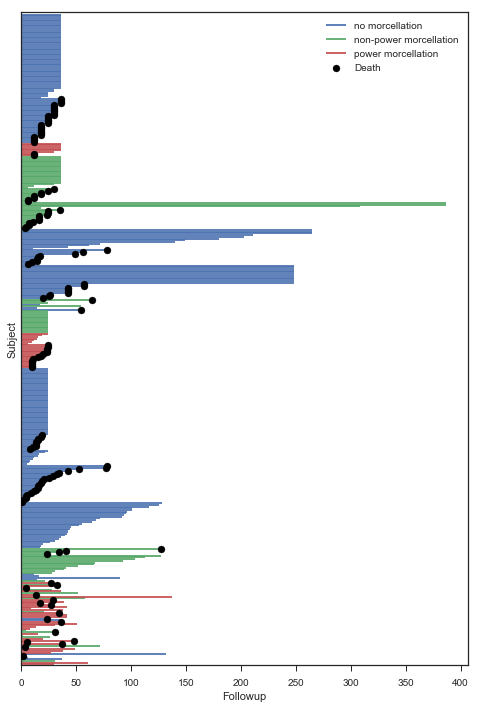

In [16]:
fig, ax = plt.subplots(figsize=(8, 12))
n_patients = kq4_data.shape[0]

time = kq4_data.event_time
event_time = time.values

ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

blue, green, red = sns.color_palette()[:3]

ax.hlines(kq4_data.index[ix0], 0, time[ix0],
          color=blue, label='no morcellation')

ax.hlines(kq4_data.index[ix1], 0, time[ix1],
          color=green, label='non-power morcellation')

ax.hlines(kq4_data.index[ix2], 0, time[ix2],
          color=red, label='power morcellation')

ax.scatter(time[kq4_data.died == 1], kq4_data.index[kq4_data.died == 1],
           color='k', zorder=10, label='Death');

ax.set_xlim(left=0)
ax.set_ylabel('Subject')
ax.set_xlabel('Followup')
ax.set_yticks([])

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='upper right');

In [17]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [18]:
kmf.fit(kq4_data.event_time, event_observed=kq4_data.died)

<lifelines.KaplanMeierFitter: fitted with 384 observations, 251 censored>

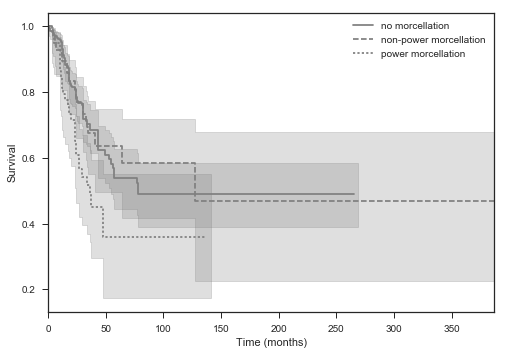

In [19]:
time = kq4_data.event_time
event = event_observed=kq4_data.died
ix0 = kq4_data.morcellation=='no'
ix1 = (kq4_data.morcellation=='yes') & (kq4_data.power=='no')
ix2 = (kq4_data.morcellation=='yes') & (kq4_data.power=='yes')

kmf.fit(time[ix0], event[ix0], label='no morcellation')
ax = kmf.plot(color='grey')

kmf.fit(time[ix1], event[ix1], label='non-power morcellation')
kmf.plot(ax=ax, ls='dashed', color='grey')

kmf.fit(time[ix2], event[ix2], label='power morcellation')
kmf.plot(ax=ax, ls='dotted', color='grey')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival')

In [20]:
from lifelines import NelsonAalenFitter
naf_baseline = NelsonAalenFitter()
naf_baseline.fit(time[ix0], event[ix0], label='no morcellation')

naf_non_power = NelsonAalenFitter()
naf_non_power.fit(time[ix1], event[ix1], label='non-power morcellation')

naf_power = NelsonAalenFitter()
naf_power.fit(time[ix2], event[ix2], label='power morcellation')

<lifelines.NelsonAalenFitter: fitted with 61 observations, 33 censored>

In [21]:
baseline_idx = naf_baseline.cumulative_hazard_[naf_baseline.cumulative_hazard_.index<=50].index[-1]
hazard_baseline = naf_baseline.cumulative_hazard_.loc[baseline_idx][0]

In [22]:
E_none = naf_baseline.event_table.loc[0].at_risk - naf_baseline.event_table.loc[baseline_idx].at_risk

In [23]:
hazard_power = naf_power.cumulative_hazard_.loc[48.7][0]
hazard_power

0.98296046325828601

In [24]:
E_power = naf_power.event_table.loc[0].at_risk - naf_power.event_table.loc[48.7].at_risk

In [25]:
hr = hazard_power/hazard_baseline
hr

1.9994576200598295

In [26]:
SE = np.sqrt(1/E_none + 1/E_power)
SE

0.15101992432741995

In [27]:
half_interval = 1.96 * SE

In [28]:
np.exp(np.log(hr) - half_interval), np.exp(np.log(hr) + half_interval)

(1.4871728509721471, 2.6882085507424263)

Summarize proportion of missing values

In [29]:
kq4_data.isnull().mean().round(2)

author               0.00
year                 0.00
refid                0.00
lms total            0.94
lms_count            0.94
preop                0.10
study_inclusion      0.00
initial_surgery      0.00
morcellation         0.00
power                0.00
first_staging        0.09
upstaged             0.66
event_time           0.00
fup_range            1.00
outcome              0.00
age                  0.59
menopausal_status    0.85
died                 0.00
dtype: float64

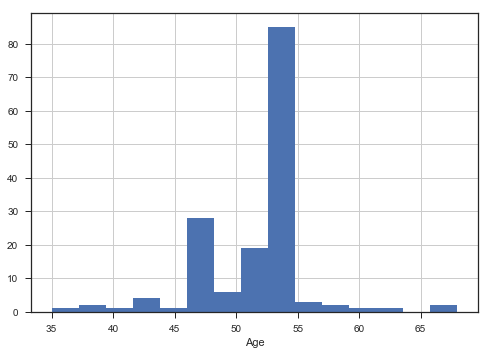

In [30]:
axes = kq4_data.age.hist(bins=15)
axes.set_xlabel('Age')

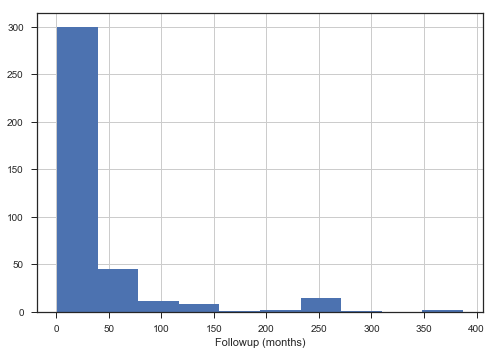

In [31]:
axes = kq4_data['event_time'].hist()
axes.set_xlabel('Followup (months)')

In [32]:
kq4_data.groupby('refid').year.min()

refid
13      2015
38      2014
145     2014
211     2012
364     2009
394     2008
405     2008
750     1999
752     2013
753     2010
783     2015
811     2015
826     2015
841     2015
900     2016
932     2016
1030    2015
1206    2015
1539    2015
1571    2015
1807    2016
1917    2016
2024    2016
2114    2016
Name: year, dtype: int64

In [33]:
model_data = (kq4_data.assign(non_power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='no'))
                      .assign(power_morcellation=(kq4_data.morcellation=='yes') & (kq4_data.power=='yes')))

In [34]:
time = model_data['event_time']
event = event_observed = model_data.died.astype(int)
n_intervals = int(time.max()+1)
n_patients = model_data.shape[0]
refid = model_data.refid.values

In [35]:
power = (model_data.power=='yes').astype(int)
morcellation = (model_data.morcellation=='yes').astype(int)

The study IDs used in the analyis:

In [36]:
studies = model_data.refid.unique()
studies

array([405, 753, 750, 145, 13, 38, 394, 783, 211, 811, 841, 752, 1807,
       1917, 1539, 2024, 2114, 1571, 1030, 900, 1206, 826, 364, 932], dtype=object)

In [37]:
study_ind = np.array([np.where(studies==id)[0][0] for id in refid])

In [38]:
from pymc3 import Normal, Deterministic, sample, HalfCauchy, Model, DensityDist, Metropolis, Potential, Exponential, Uniform
from pymc3 import traceplot, forestplot, summary, sample_ppc
import theano.tensor as tt

In [39]:
with Model() as exp_model:

    # Study random effect
    μ = Normal('μ', 0, sd=100)
    σ = pm.HalfCauchy('σ', 2.5)
    ζ = pm.Normal('ζ', 0, 1, shape=len(studies))
    θ = (μ + ζ*σ)[study_ind]

    # Effects of morcellation and power
    β = Normal('β', mu=0.0, sd=100, shape=2)

    # Survival rates
    λ = Deterministic('λ', tt.exp(θ + β[0] * morcellation + β[1] * power))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * tt.log(λ) - λ * time

    survival = DensityDist('survival', logp, observed={'event':event})


In [40]:
n_iterations = 5000
n_burn = 1000

In [41]:
with exp_model:
    exp_trace = sample(n_iterations, random_seed=rseed, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -790.53: 100%|██████████| 200000/200000 [00:16<00:00, 12003.68it/s]   
Finished [100%]: Average ELBO = -790.43
100%|██████████| 5000/5000 [00:14<00:00, 336.83it/s]


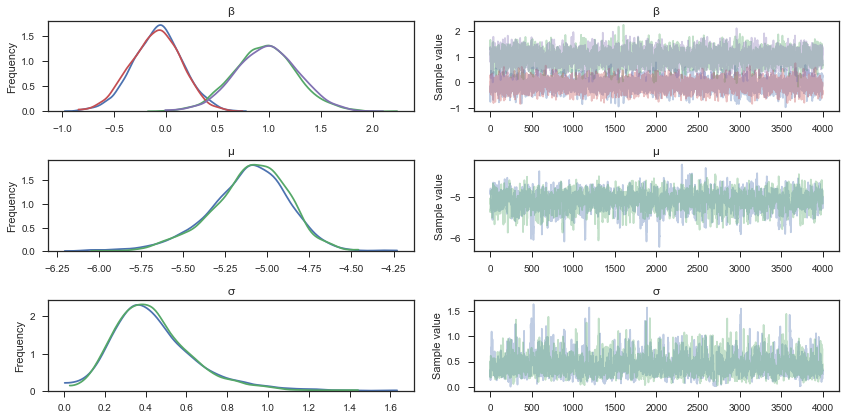

In [42]:
traceplot(exp_trace[n_burn:], varnames=['β', 'μ', 'σ']);

In [43]:
summary(exp_trace[n_burn:], varnames=['β'])


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.087           0.243            0.005            [-0.581, 0.377]
  0.967            0.305            0.005            [0.382, 1.586]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.577         -0.250         -0.080         0.077          0.382
  0.369          0.763          0.970          1.168          1.575



In [44]:
baseline_hazard = np.exp(exp_trace['μ'][n_burn:])
non_power_hazard = np.exp(exp_trace['μ'][n_burn:] + exp_trace['β'][n_burn:, 0])
power_hazard = np.exp(exp_trace['μ'][n_burn:] + exp_trace['β'][n_burn:, 0] + exp_trace['β'][n_burn:, 1])

Since this is a constant-hazard model, we can easily summarize the hazard estimates.

In [45]:
hazard_df = pd.DataFrame({'baseline':baseline_hazard, 'non-power':non_power_hazard, 'power':power_hazard})
hazard_df.describe(percentiles=[0.025, 0.975]).T[['mean', '2.5%', '97.5%']].round(4)

,mean,2.5%,97.5%
baseline,0.0062,0.0036,0.0091
non-power,0.0058,0.0030,0.0092
power,0.0150,0.0086,0.0229


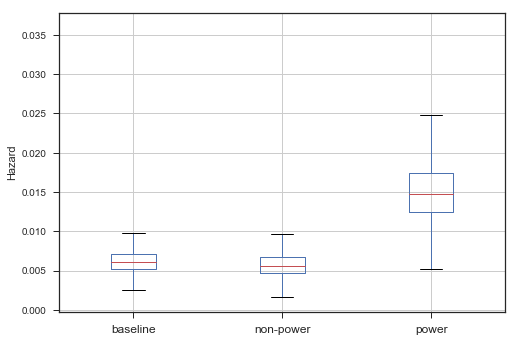

In [46]:
hazard_df.boxplot()
plt.ylabel('Hazard');

In [47]:
def cum_hazard(hazard, n=n_intervals):
    return (np.arange(n) * hazard.reshape(-1,1)).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [48]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05, **kwargs):

    mean = f(hazard.mean(axis=0), **kwargs)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard, **kwargs), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean.squeeze(), color=color, label=label);

In [49]:
interval_bounds = np.arange(0, time.max() + 2, 1)

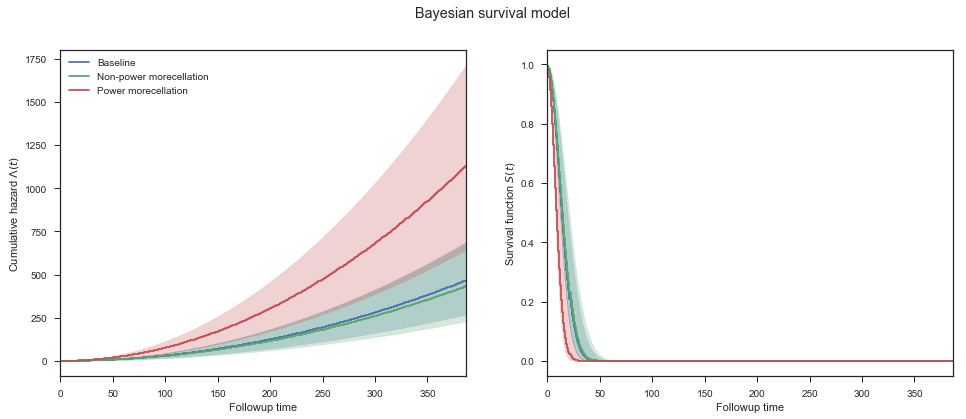

In [50]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_hazard, cum_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_hazard, cum_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_hazard, cum_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, time.max());
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_hazard, survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, time.max());
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

Unfortunately, the exponential (*i.e.* constant hazard) model does not seem to fit the data, based on the comparison between the K-M curves and the survival function. 

Below, we try a Weibull model for the survival function.

## Weibull survival model

In [51]:
from pymc3 import Weibull, df_summary

In [52]:
with Model() as weibull_model:

    # Study random effect
    μ = Normal('μ', 0, sd=10)
    σ = pm.HalfCauchy('σ', 2.5)
    ζ = pm.Normal('ζ', 0, 1, shape=len(studies))
    θ = (μ + ζ*σ)[study_ind]

    # Weibull shape parameter
    k = pm.HalfCauchy('k', 2.5)
    # Effects of morcellation and power
    β = Normal('β', mu=0.0, sd=100, shape=2)

    # Weibull scales
    λ = Deterministic('λ', tt.exp(θ + β[0]*morcellation + β[1]*power))

    # Wewibull survival likelihood, accounting for censoring
    def logp(event):
        return event*(tt.log(k) + tt.log(λ) + (k-1)*tt.log(event_time)) - (λ * event_time**k)

    survival = DensityDist('survival', logp, observed={'event':event})


In [53]:
with weibull_model:
    weibull_trace = sample(n_iterations, njobs=2, random_seed=rseed)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -792.15: 100%|██████████| 200000/200000 [00:22<00:00, 8850.39it/s]    
Finished [100%]: Average ELBO = -792.08
100%|██████████| 5000/5000 [00:21<00:00, 233.64it/s]


In [55]:
summary(weibull_trace[n_burn:], varnames=['β']);


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.064           0.241            0.004            [-0.541, 0.401]
  0.904            0.312            0.006            [0.288, 1.517]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.559         -0.222         -0.061         0.103          0.387
  0.298          0.688          0.899          1.110          1.532



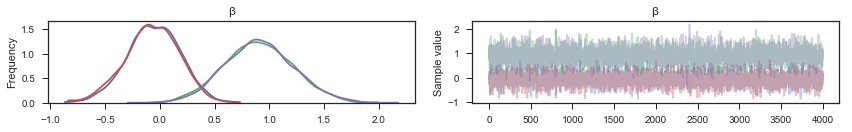

In [56]:
traceplot(weibull_trace[n_burn:], varnames=['β']);

Weibull shape parameter (`k`) and study random effect hyperparameters (`μ` and `σ`)

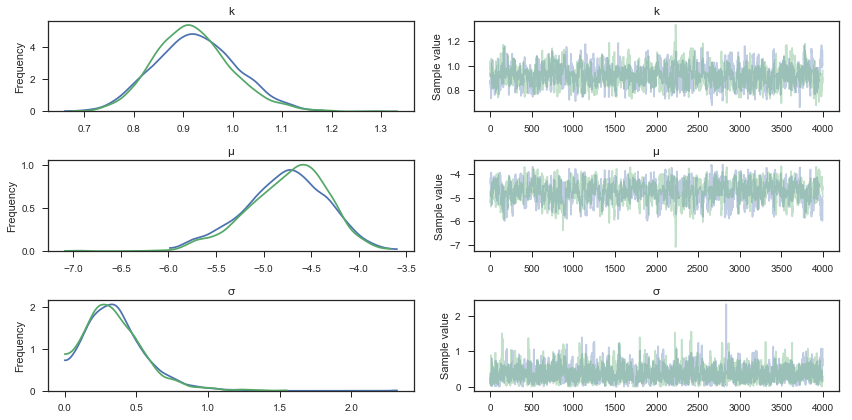

In [57]:
traceplot(weibull_trace[n_burn:], varnames=['k', 'μ', 'σ']);

### Plot survival curves

In [58]:
baseline_lam = np.exp(weibull_trace['μ'][n_burn:])
non_power_lam = np.exp(weibull_trace['μ'][n_burn:] + weibull_trace['β'][n_burn:, 0])
power_lam = np.exp(weibull_trace['μ'][n_burn:] + weibull_trace['β'][n_burn:, 0] + weibull_trace['β'][n_burn:, 1])
k_trace = weibull_trace['k'][n_burn:]

In [59]:
n_intervals = 120
interval_bounds = np.arange(0, n_intervals + 1, 1)

In [66]:
def cum_weibull_hazard(lam, k=k_trace, t=n_intervals):
    return (lam.reshape(-1,1) * np.arange(t)) ** k.reshape(-1,1)

def weibull_survival(lam, k=k_trace, t=n_intervals):
    return np.exp(-cum_weibull_hazard(lam, k, t))

In [91]:
def plot_with_hpd(x, lam, f, ax, linestyle='-', color=None, label=None, alpha=0.05, debug=False, **kwargs):

    m = np.median(f(lam, **kwargs), axis=0)
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(lam, **kwargs), percentiles, axis=0)
    
    if debug:
        import pdb;pdb.set_trace()
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, m, color=color, linestyle=linestyle, label=label);

In [101]:
greys = ['#969696', '#636363', '#252525']

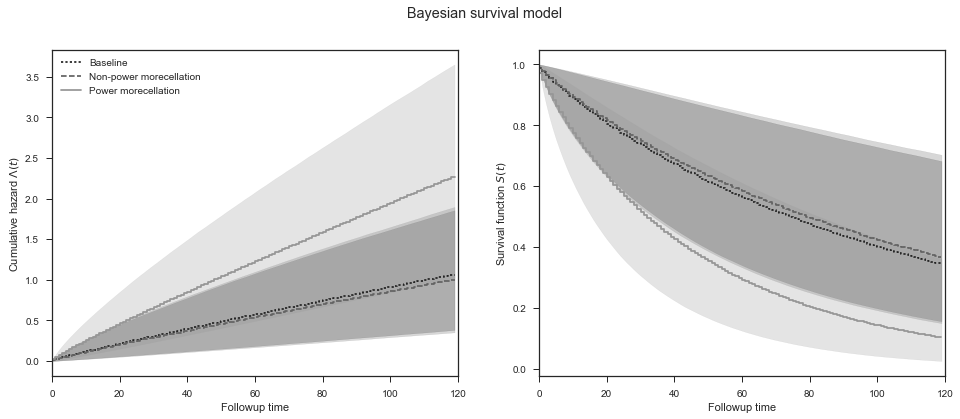

In [105]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_lam, cum_weibull_hazard,
              hazard_ax, color=greys[2], linestyle=':', label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_lam, cum_weibull_hazard,
              hazard_ax, color=greys[1], linestyle='--', label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_lam, cum_weibull_hazard,
              hazard_ax, color=greys[0], label='Power morecellation')

hazard_ax.set_xlim(0, n_intervals);
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_lam, weibull_survival,
              surv_ax, color=greys[2], linestyle=':')
plot_with_hpd(interval_bounds[:-1], non_power_lam, weibull_survival,
              surv_ax, color=greys[1], linestyle='--')
plot_with_hpd(interval_bounds[:-1], power_lam, weibull_survival,
              surv_ax, color=greys[0],)

surv_ax.set_xlim(0, n_intervals);
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

The above is a much more reasonable fit, compared to the exponential model.

### Summary statistics

Time (months) at which mean survival is 0.5 for each subgroup:

In [69]:
baseline_survival = weibull_survival(baseline_lam)
non_power_survival = weibull_survival(non_power_lam)
power_survival = weibull_survival(power_lam)

No morcellation:

In [70]:
np.where(baseline_survival.mean(axis=0)<=0.5)[0][0]

78

Non-power morcellation:

In [71]:
np.where(non_power_survival.mean(axis=0)<=0.5)[0][0]

83

Power morcellation:

In [72]:
np.where(power_survival.mean(axis=0)<=0.5)[0][0]

34

Proportion alive after 5 years

In [73]:
baseline_survival_5 = baseline_survival[:, 60]
non_power_survival_5 = non_power_survival[:, 60]
power_survival_5 = power_survival[:, 60]

In [74]:
print('Baseline 5-year median survival: {0} {1}'.format(np.median(baseline_survival), 
                                                        np.percentile(baseline_survival, [2.5, 97.5])))

Baseline 5-year median survival: 0.6024758891607414 [ 0.23677862  0.97697928]


In [75]:
print('Non-power morcellation median 5-year survival: {0} {1}'.format(np.median(non_power_survival_5), 
                                                        np.percentile(non_power_survival_5, [2.5, 97.5])))

Non-power morcellation median 5-year survival: 0.5878097486450417 [ 0.3335082   0.84476959]


In [76]:
print('Power morcellation median 5-year survival: {0} {1}'.format(np.median(power_survival_5), 
                                                        np.percentile(power_survival_5, [2.5, 97.5])))

Power morcellation median 5-year survival: 0.29853703012870875 [ 0.12521838  0.6107794 ]


Ratio of hazards at 5 years between power and non-power morecellation

In [78]:
def weibull_hazard(lam, t, k=k_trace):
    return (k.reshape(-1,1) * lam.reshape(-1,1) * t**(k.reshape(-1,1) - 1))

In [79]:
non_power_hazard_5 = weibull_hazard(non_power_lam, 60).mean(axis=0)
non_power_hazard_5

array([ 0.00557988])

In [80]:
power_hazard_5 = weibull_hazard(power_lam, 60).mean(axis=0)
power_hazard_5

array([ 0.01365745])

In [81]:
hazard_ratio = weibull_hazard(power_lam, 60)/weibull_hazard(non_power_lam, 60)

In [83]:
print('Hazard ratio (power vs non-power) at 5 years: {0} {1}'.format(hazard_ratio.mean(), 
                                                                     np.percentile(hazard_ratio, [2.5, 97.5])))

Hazard ratio (power vs non-power) at 5 years: 2.578980643435292 [ 1.34570792  4.59722682]
